In [1]:
import re
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# read ground truth data
data = []

ground_truth_file_path = '../results/ground_truth.csv'

df_gt = pd.read_csv(ground_truth_file_path,index_col=0)
df_gt.head()

,A,B,C,D,E,F,G,H,I,J
A,--,A,C,--,--,F,G,--,--,J
B,A,--,--,D,B,F,G,B,B,--
C,C,--,--,C,C,C,G,C,C,--
D,--,D,C,--,--,F,G,D,--,J
E,--,B,C,--,--,E,G,--,--,J


In [3]:
# read real data from test run
data = []

# pattern = r'Users: (?P<current_user>.)(?P<interrupting_user>.). Gazebo: (?P<gazebo>\S+). Negotiation rounds: (?P<rounds>\d+). Preparation time: (?P<prep_time>\d+\.\d+) seconds. Negotiation time: (?P<time>\d+\.\d+) seconds. (?P<result>\S+)'
pattern = r'Users: (?P<current_user>.)(?P<interrupting_user>.). Gazebo: (?P<gazebo>\S+). Negotiation rounds: (?P<rounds>\d+). Preparation time: (?P<prep_time>\d+\.\d+) seconds. Negotiation time: (?P<time>\d+\.\d+) seconds. Result: (?P<result>\S+)'

log_file_path = '../results/validation-without_gazebo.log'

# for log_file_path in sim_files:
with open(log_file_path, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            current_user = match.group("current_user")
            interrupting_user = match.group("interrupting_user")
            gazebo = bool(match.group("gazebo")) 
            rounds = int(match.group("rounds")) // 2 + (int(match.group("rounds")) % 2 > 0)
            time = float(match.group("time"))
            prep_time = float(match.group("prep_time"))
            result = match.group("result").lower()

            # if not gazebo:
            data.append({"current_user": current_user, "interrupting_user": interrupting_user, "rounds": rounds, "preparation_time": prep_time, "negotiation_time": time, "result": result})
        else:
            print("Diverging result: ")
            print(line)
df_rd = pd.DataFrame(data)
df_rd.head()

,current_user,interrupting_user,rounds,preparation_time,negotiation_time,result
0,A,B,2,1.047,0.024,current
1,A,C,3,1.098,0.023,interrupting
2,A,D,3,1.012,0.021,no-agreement
3,A,E,3,1.011,0.022,no-agreement
4,A,F,3,1.024,0.031,interrupting


In [24]:
# validation: check whether negotiation had expected outcome!
expected_outcome, differing_outcome = [],[]
for index, row in df_rd.iterrows():
    expected = df_gt.at[row["current_user"],row["interrupting_user"]]
    if (row["result"] == "current" and expected == row["current_user"]) or (row["result"] == "interrupting" and expected == row["interrupting_user"]) or (row["result"] == "no-agreement" and expected == "--"):
        expected_outcome.append(expected)
    else:
        differing_outcome.append((row["result"],expected))

print("Negotiations with expected outcome: ", len(expected_outcome))
print("Negotiations with differing outcome: ", len(differing_outcome))
print("Percentage of negotiation with expected outcome: ", len(expected_outcome)/(len(expected_outcome)+len(differing_outcome))*100, "%")

Negotiations with expected outcome:  90
Negotiations with differing outcome:  0
Percentage of negotiation with expected outcome:  100.0 %


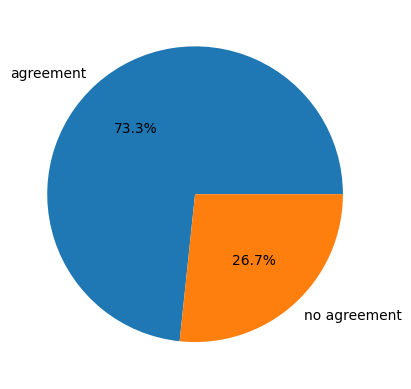

In [54]:
# analyze percentage of agreement vs non-agreement
no_agreement = df_rd.loc[df_rd["result"] == "no-agreement"]
current = df_rd.loc[df_rd["result"] == "current"]
interrupting = df_rd.loc[df_rd["result"] == "interrupting"]

plt.pie([(len(current) + len(interrupting))/90, len(no_agreement)/90], labels = ["agreement", "no agreement"], autopct='%1.1f%%')
# plt.legend()
plt.show()

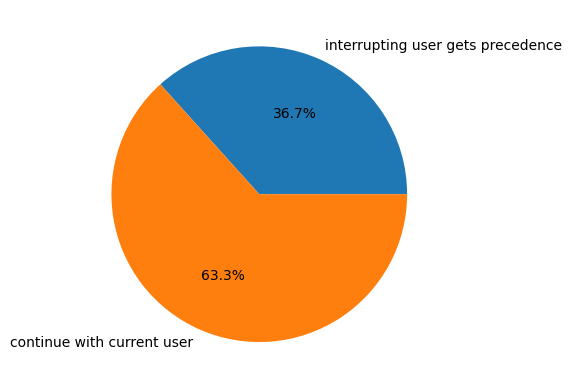

In [57]:
# analyze percentage of agreement vs non-agreement
no_agreement = df_rd.loc[df_rd["result"] == "no-agreement"]
current = df_rd.loc[df_rd["result"] == "current"]
interrupting = df_rd.loc[df_rd["result"] == "interrupting"]

print()
plt.pie([len(interrupting)/90,(len(current) + len(no_agreement))/90], labels = ["interrupting user gets precedence", "continue with current user"], autopct='%1.1f%%')
# plt.legend()
plt.show()

In [52]:
users_list = df_rd["current_user"].unique()
users_interrupting_list = df_rd["interrupting_user"].unique()

for u1 in users_list:
    if u1 not in users_interrupting_list:
        print(f"user {u1} is not in interrupting users list!!")
    for u2 in users_list:
        if u1 == u2 : continue
        assignment1 = df_rd.loc[(df_rd["current_user"]==u1) & (df_rd["interrupting_user"]==u2)]["result"].item()
        assignment2 = df_rd.loc[(df_rd["current_user"]==u2) & (df_rd["interrupting_user"]==u1)]["result"].item()
        if assignment1 == "no-agreement" and assignment2 == "no-agreement" or assignment1 == "current" and assignment2 == "interrupting" or assignment1 == "interrupting" and assignment2 == "current":
            continue
        print("results with switched roles are not consistent!")
        print(f"users: {u1},{u2}")
        print(f"assignment1: {assignment1}, assignment2: {assignment2}")


In [4]:
# read real data from gazebo run
data = []

pattern = r'Users: (?P<current_user>.)(?P<interrupting_user>.). Gazebo: (?P<gazebo>\S+). Negotiation rounds: (?P<rounds>\d+). Preparation time: (?P<prep_time>\d+\.\d+) seconds. Negotiation time: (?P<time>\d+\.\d+) seconds. Result: (?P<result>\S+)'
# pattern = r'Users: (?P<current_user>.)(?P<interrupting_user>.) Negotiation rounds: (?P<rounds>\d+). Preparation time: (?P<prep_time>\d+\.\d+) seconds. Negotiation time: (?P<time>\d+\.\d+) seconds. (?P<result>\S+)'

log_file_path = '../results/results_gazebo.log'

# for log_file_path in sim_files:
with open(log_file_path, 'r') as file:
    for line in file:
        match = re.search(pattern, line)
        if match:
            current_user = match.group("current_user")
            interrupting_user = match.group("interrupting_user")
            gazebo = bool(match.group("gazebo")) 
            rounds = int(match.group("rounds")) // 2 + (int(match.group("rounds")) % 2 > 0)
            time = float(match.group("time"))
            prep_time = float(match.group("prep_time"))
            result = match.group("result").lower()

            if gazebo:
                data.append({"current_user": current_user, "interrupting_user": interrupting_user, "rounds": rounds, "preparation_time": prep_time, "negotiation_time": time, "result": result})
        else:
            print("Diverging result: ")
            print(line)
df_gazebo = pd.DataFrame(data)
df_gazebo.head()

,current_user,interrupting_user,rounds,preparation_time,negotiation_time,result
0,A,B,2,3.016,0.052,current
1,A,C,3,3.022,0.033,interrupting
2,A,D,3,3.025,0.048,no-agreement
3,A,E,3,3.013,0.025,no-agreement
4,A,F,3,3.008,0.032,interrupting


In [8]:
expected_outcome, differing_outcome = [],[]
for index, row in df_gazebo.iterrows():
    expected = df_gt.at[row["current_user"],row["interrupting_user"]]
    if (row["result"] == "current" and expected == row["current_user"]) or (row["result"] == "interrupting" and expected == row["interrupting_user"]) or (row["result"] == "no-agreement" and expected == "--"):
        expected_outcome.append(expected)
    else:
        differing_outcome.append((row["result"],expected))

print("With gazebo:")
print("Negotiations with expected outcome: ", len(expected_outcome))
print("Negotiations with differing outcome: ", len(differing_outcome))
print("Percentage of negotiation with expected outcome: ", len(expected_outcome)/(len(expected_outcome)+len(differing_outcome))*100, "%")

With gazebo:
Negotiations with expected outcome:  45
Negotiations with differing outcome:  0
Percentage of negotiation with expected outcome:  100.0 %


Average preparation time (without gazebo): 1.0251 s


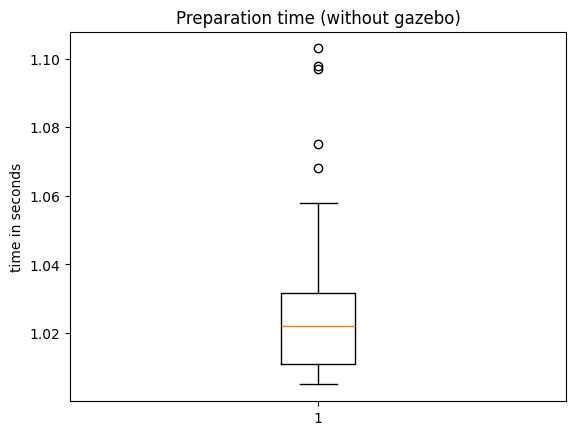

In [9]:
# analyze average preparation time without gazebo
print("Average preparation time (without gazebo): %.4f" % df_rd["preparation_time"].mean(), "s")

plt.title("Preparation time (without gazebo)")
plt.boxplot(df_rd["preparation_time"])
plt.ylabel("time in seconds")
plt.show()

Average preparation time (with gazebo): 3.0138 s


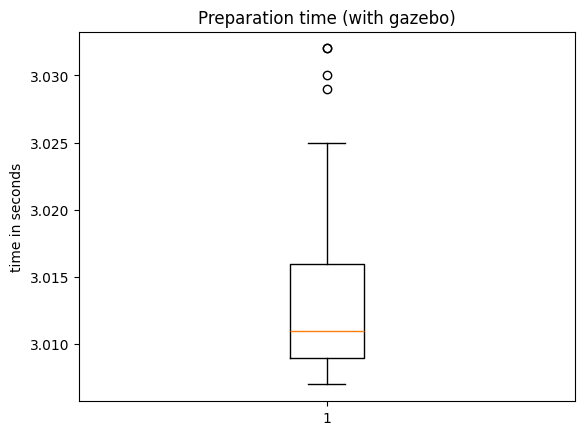

In [10]:
# analyze average preparation time with gazebo
print("Average preparation time (with gazebo): %.4f" % df_gazebo["preparation_time"].mean(), "s")

plt.title("Preparation time (with gazebo)")
plt.boxplot(df_gazebo["preparation_time"])
plt.ylabel("time in seconds")
plt.show()

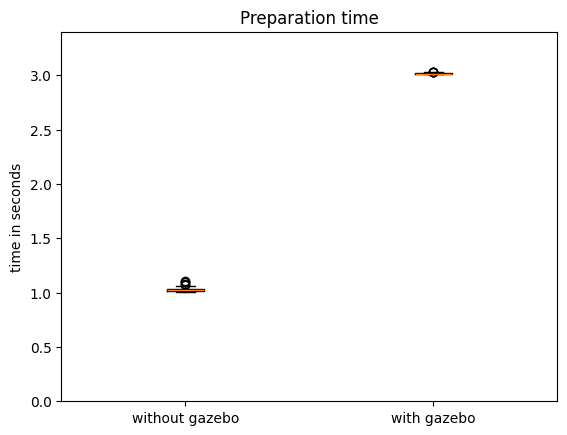

In [11]:
# compare preparation time
plt.title("Preparation time")
plt.boxplot([df_rd["preparation_time"],df_gazebo["preparation_time"]], tick_labels=["without gazebo","with gazebo"])
plt.ylabel("time in seconds")
plt.ylim([0,3.4])
plt.show()

Average negotiation time (without gazebo): 0.0223 s


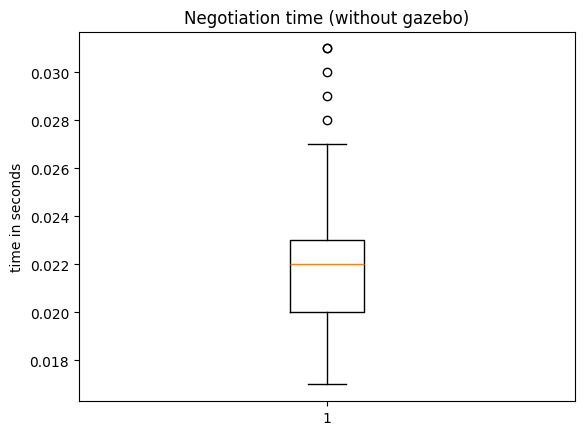

In [12]:
# analyze average negotiation time without gazebo
print("Average negotiation time (without gazebo): %.4f" % df_rd["negotiation_time"].mean(), "s")
plt.boxplot(df_rd["negotiation_time"])
plt.title("Negotiation time (without gazebo)")
plt.ylabel("time in seconds")
plt.show()

Average negotiation time (with gazebo): 0.0223 s


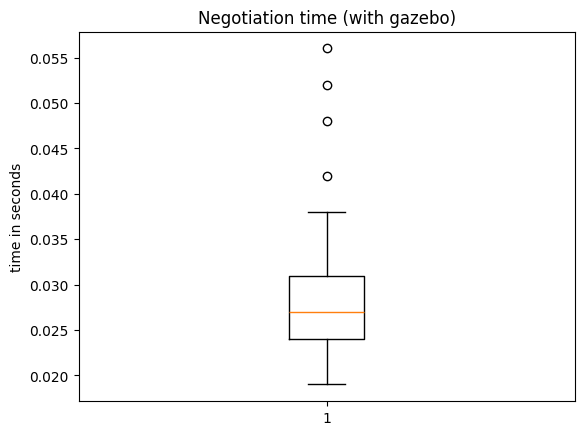

In [13]:
# analyze average negotiation time with gazebo
print("Average negotiation time (with gazebo): %.4f" % df_rd["negotiation_time"].mean(), "s")
plt.title("Negotiation time (with gazebo)")
plt.boxplot(df_gazebo["negotiation_time"])
plt.ylabel("time in seconds")
plt.show()

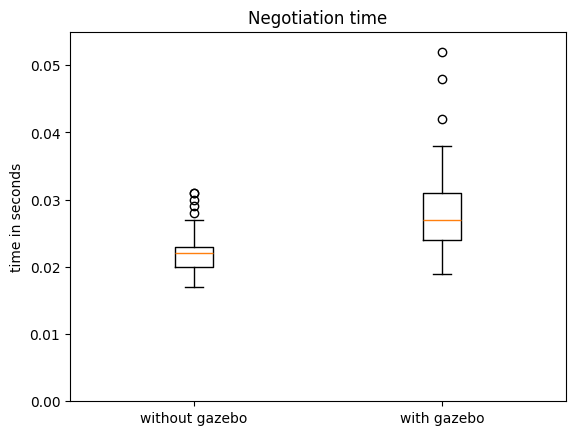

In [20]:
# compare negotiation time 
plt.title("Negotiation time")
plt.boxplot([df_rd["negotiation_time"],df_gazebo["negotiation_time"]],tick_labels=["without gazebo","with gazebo"])
plt.ylabel("time in seconds")
plt.ylim([0,0.055])
plt.show()

Average total time (without gazebo): 1.0474 s


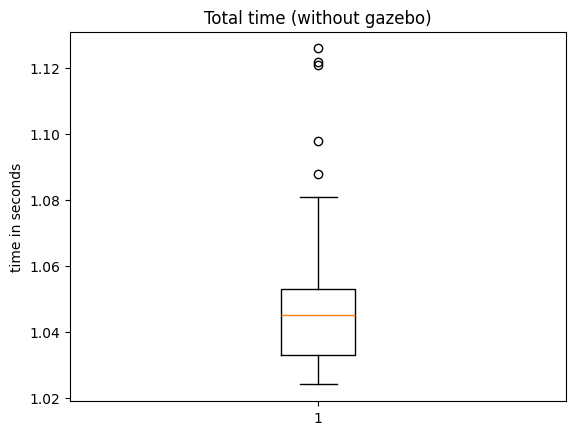

In [15]:
# analyze average preparation + negotiation time without gazebo
total_time = df_rd[["preparation_time","negotiation_time"]].sum(axis=1)
print("Average total time (without gazebo): %.4f" % total_time.mean(), "s")
plt.boxplot(total_time)
plt.title("Total time (without gazebo)")
plt.ylabel("time in seconds")
plt.show()

Average total time (with gazebo): 3.0426 s


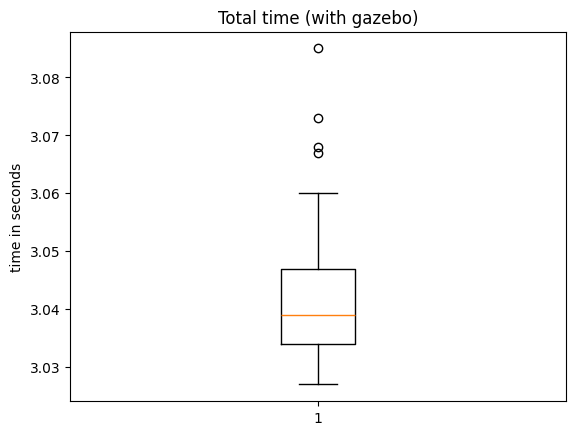

In [16]:
# analyze average preparation + negotiation time with gazebo
total_time = df_gazebo[["preparation_time","negotiation_time"]].sum(axis=1)
print("Average total time (with gazebo): %.4f" % total_time.mean(), "s")
plt.boxplot(total_time)
plt.title("Total time (with gazebo)")
plt.ylabel("time in seconds")
plt.show()

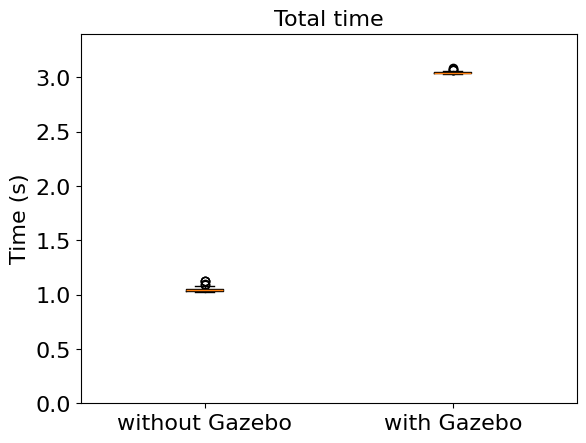

In [8]:
# compare preparation + negotiation time
plt.boxplot([df_rd[["preparation_time","negotiation_time"]].sum(axis=1), df_gazebo[["preparation_time","negotiation_time"]].sum(axis=1)],tick_labels=["without Gazebo", "with Gazebo"])
plt.title("Total time",fontsize=16)
plt.ylabel("Time (s)",fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylim([0,3.4])
plt.savefig("comp_total.pdf", format="pdf", bbox_inches="tight")
plt.show()

Average number of rounds: 2.7111


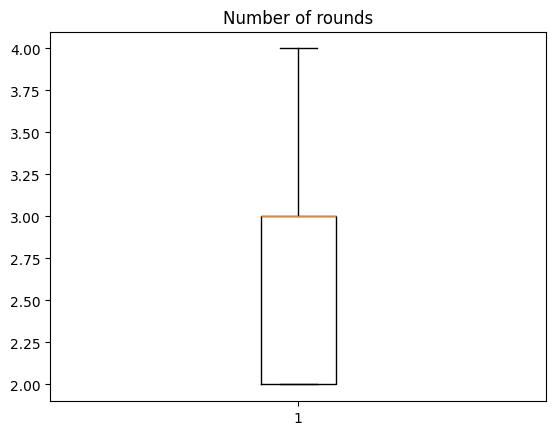

In [18]:
# analyze average number of rounds
print("Average number of rounds: %.4f" % df_rd["rounds"].mean())
plt.boxplot(df_rd["rounds"])
plt.title("Number of rounds")
plt.show()

Average number of rounds (with gazebo): 2.7111


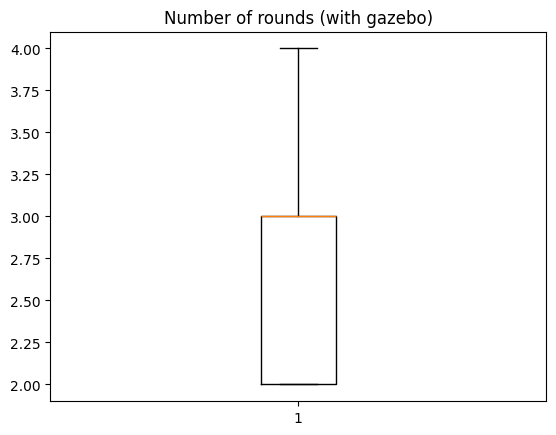

In [19]:
# analyze average number of rounds
print("Average number of rounds (with gazebo): %.4f" % df_gazebo["rounds"].mean())
plt.boxplot(df_rd["rounds"])
plt.title("Number of rounds (with gazebo)")
plt.show()